In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

## Load images dataset

In [ ]:
from PIL import Image

IMAGE_DIR = "../fashion_images/dataset_clean"

images = []
image_paths = []

# iterate to call images data
for root, _, files in os.walk(IMAGE_DIR):
    for filename in files:
        if filename.lower().endswith(".jpg"):
            path = os.path.join(root, filename)
            image = Image.open(path).convert("RGB")
            images.append(image)
            image_paths.append(path)
    
print(f"Loaded {len(images)} JPG Images")

Loaded 8625 JPG Images


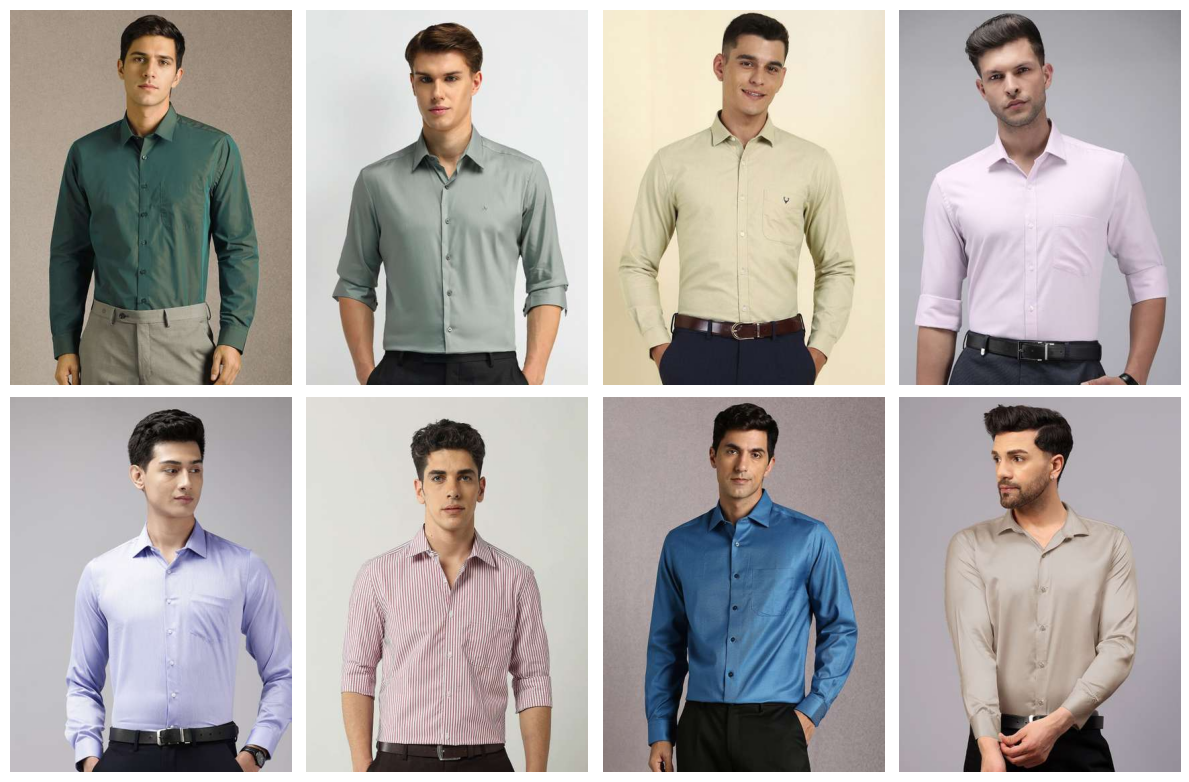

In [ ]:
# show multiple images
import matplotlib.pyplot as plt

def show_images(images, cols=4, figsize=(12, 8)):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(rows, cols,  i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Usage
show_images(images[:8], cols=4)

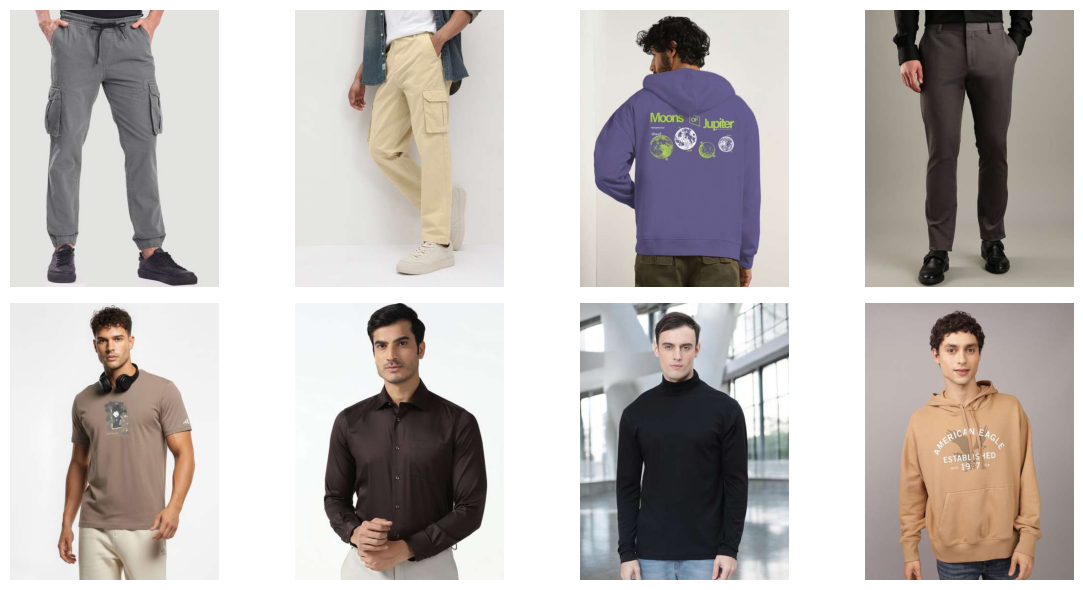

In [ ]:
# Show random images

import random
import matplotlib.pyplot as plt

def show_random_images(images, n=8, cols=4, figsize=(12, 6)):
    n = min(n, len(images))
    selected = random.sample(images, n)

    rows = (n + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, img in enumerate(selected):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Usage
show_random_images(images, n=8)

# Data pipeline

### 1. Common Matching Scenarios
### 2. Complete Matching Pipeline
### 3. Handle missmatch data pipeline
### 4. Create Image-Metadata Dictionary
### 5. Load and Preprocess Images
### 6. Create Dataset Class for PyTorch
### 7. Quality Checks

## Common Matching Scenarios

In [ ]:
from collections import defaultdict

# Direct matching pipeline

# =============================================================================
# CONFIGURATION
# =============================================================================
PARQUET_PATH = "hdfs/fashion_dataset"
IMAGE_DIR = '../fashion_images/dataset_clean'
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.JPG', '.PNG', '.JPEG')

# Load dataset
df = pd.read_parquet(PARQUET_PATH)

# =============================================================================
# SCAN ALL AVAILABLE IMAGES - FIXED TO HANDLE DUPLICATES
# =============================================================================
available_images = {}  # Key: "category_filename" -> Value: full_path
category_counts = defaultdict(int)

print("Scanning images...")

for category in os.listdir(IMAGE_DIR):
    category_path = os.path.join(IMAGE_DIR, category)
    
    if not os.path.isdir(category_path):
        continue
    
    print(f"📁 Scanning: {category}/", end=" ")
    count = 0
    
    for file in os.listdir(category_path):
        if file.endswith(VALID_EXTENSIONS):
            # CREATE UNIQUE KEY: category + filename
            unique_key = f"{category}_{file}"  # e.g., "formal_shirts_img_0235.jpg"
            
            available_images[unique_key] = os.path.join(category_path, file)
            category_counts[category] += 1
            count += 1
    
    print(f"✓ {count:,} images")

# =============================================================================
# RESULTS
# =============================================================================
print("\n" + "="*60)
print("SCAN RESULTS")
print("="*60)
print(f"Total available images: {len(available_images):,}")
print(f"Total dataset rows: {len(df):,}")
print(f"Expected images: 8,625")
print(f"Match rate: {len(available_images)/8625*100:.1f}%")

print("\n=== Images per category ===")
for cat, count in sorted(category_counts.items()):
    print(f"  {cat:20s}: {count:,}")

Scanning images...
📁 Scanning: formal_shirts/ ✓ 992 images
📁 Scanning: printed_tshirts/ ✓ 1,097 images
📁 Scanning: printed_hoodies/ ✓ 1,056 images
📁 Scanning: jeans/ ✓ 1,135 images
📁 Scanning: solid_tshirts/ ✓ 1,040 images
📁 Scanning: formal_pants/ ✓ 986 images
📁 Scanning: casual_shirts/ ✓ 1,182 images
📁 Scanning: men_cargos/ ✓ 1,137 images

SCAN RESULTS
Total available images: 8,625
Total dataset rows: 1,100,000
Expected images: 8,625
Match rate: 100.0%

=== Images per category ===
  casual_shirts       : 1,182
  formal_pants        : 986
  formal_shirts       : 992
  jeans               : 1,135
  men_cargos          : 1,137
  printed_hoodies     : 1,056
  printed_tshirts     : 1,097
  solid_tshirts       : 1,040


In [ ]:
# Convert item_id to string for matching
df['item_id_str'] = df['item_id'].astype(str)

# Complete Matching Pipeline

In [ ]:
# ⚠️ THIS IS BAD - ONLY USE FOR TESTING
# Randomly assigns images to items (NOT accurate for real use)

import random

print("\n⚠️  WARNING: No proper mapping found")
print("Assigning images randomly for testing purposes only!\n")

# Group images by subcategory
images_by_subcat = {}
for key, path in available_images.items():
    subcat = key.split('_img_')[0]
    if subcat not in images_by_subcat:
        images_by_subcat[subcat] = []
    images_by_subcat[subcat].append(path)

# Assign randomly
def assign_random_image(row):
    subcat = row['subcategory']
    if subcat in images_by_subcat and len(images_by_subcat[subcat]) > 0:
        return random.choice(images_by_subcat[subcat])
    return None

df['image_path'] = df.apply(assign_random_image, axis=1)

matched = df['image_path'].notna().sum()
print(f"Randomly assigned: {matched:,} images")

# Extract just the filename from the full path
df['image_path'] = df['image_path'].apply(lambda x: os.path.basename(x) if pd.notna(x) else None)


⚠️  WARNING: No proper mapping found
Assigning images randomly for testing purposes only!

Randomly assigned: 1,100,000 images


In [ ]:
df[["subcategory", "image_path"]]

,subcategory,image_path
0,men_cargos,img_0642.jpg
1,formal_shirts,img_0307.jpg
2,formal_shirts,img_0596.jpg
3,printed_tshirts,img_0505.jpg
4,formal_shirts,img_0977.jpg
...,...,...
1099995,solid_tshirts,img_0889.jpg
1099996,formal_pants,img_0767.jpg
1099997,men_cargos,img_0660.jpg
1099998,solid_tshirts,img_0388.jpg


# Tensorflow deep learning model
# Purpose project:
### **Extracting images features to model which are integrated to business problem**
### * **enabling robust modeling of user preferences.**
### * **recommendation algorithms have progressively evolved from linear models to deep neural networks**
### * **multimodal deep learning framework that integrates visual, textual, and price features for business insight**
### * **Try to match outfit features top and bottom wearing (Optional task)**

In [ ]:
import tensorflow as tf